# Index-2 linear DAE (Spiteri Ch. 10) solved via index reduction and RadauDAE

We solve the attached linear index-2 DAE from Spiteri’s lecture notes (Chapter 10) using a pedagogical index-reduction step that yields an equivalent index-1 semi-explicit DAE amenable to RadauDAE. Then we compare against the exact solution and report errors and solver statistics.

Reference:
- Spiteri, R. J. Numerical Methods for DAEs. University of Saskatchewan lecture notes, Chapter 10.

---

## 1) Original index-2 DAE and exact solution

The given system is:
$$
\begin{bmatrix}
0 & 0 \\
1 & \eta\,t
\end{bmatrix}
\dot{\mathbf{y}}(t) +
\begin{bmatrix}
1 & \eta\,t \\
0 & 1+\eta
\end{bmatrix}
\mathbf{y}(t) =
\begin{bmatrix}
q(t) \\
0
\end{bmatrix},
\quad \mathbf{y} = \begin{bmatrix} y_1 \\ y_2 \end{bmatrix}.
$$

For a differentiable $q(t)$, the exact solution is:
$$
y_1(t) = q(t) + \eta\,t\,\dot{q}(t), \qquad y_2(t) = -\dot{q}(t).
$$

We choose $q(t) = \sin(t)$ and $\eta = 0.2$. Then $q'(t) = \cos(t)$ and:
- $y_1(t) = \sin(t) + 0.2\,t\,\cos(t)$
- $y_2(t) = -\cos(t)$

Initial conditions (from exact solution at $t=0$):
- $y_1(0) = \sin(0) + 0.2\cdot 0 \cdot \cos(0) = 0$
- $y_2(0) = -\cos(0) = -1$

---

## 2) Pedagogical index reduction to an index-1 semi-explicit DAE

RadauDAE (as implemented here) requires a constant mass matrix. The original system has a time-dependent mass term ($\eta t$ multiplying $\dot{y}_2$), which is not directly supported. We therefore perform a standard index-reduction step:

- The algebraic equation (row 1) is:
  $$
  y_1 + \eta\,t\,y_2 = q(t),
  $$
  which defines $y_1$ algebraically in terms of $y_2$ and $t$.

- Differentiate this algebraic relation once:
  $$
  \dot{y}_1 + \eta\,t\,\dot{y}_2 + \eta\,y_2 = \dot{q}(t).
  $$

- The differential row (row 2) is:
  $$
  \dot{y}_1 + \eta\,t\,\dot{y}_2 + (1+\eta)\,y_2 = 0.
  $$

- Equating the two expressions for $\dot{y}_1 + \eta t \dot{y}_2$ yields:
  $$
  \dot{q}(t) - \eta\,y_2 = -(1+\eta)\,y_2 \;\Rightarrow\; \dot{q}(t) = -y_2.
  $$

- Differentiating $y_2 = -\dot{q}(t)$ gives a clean differential equation:
  $$
  \dot{y}_2 = -\ddot{q}(t).
  $$

- Retain the original algebraic equation:
  $$
  y_1 + \eta\,t\,y_2 = q(t).
  $$

Thus we obtain a semi-explicit index-1 DAE in variables $(y_1, y_2)$:
- Differential equation (for $y_2$): $y_2' = -\ddot{q}(t)$
- Algebraic constraint: $y_1 + \eta\,t\,y_2 - q(t) = 0$

This formulation has a constant mass matrix:
$$
M = \begin{bmatrix} 0 & 0 \\ 0 & 1 \end{bmatrix},
$$
with variable index $[1, 0]$ (algebraic $y_1$, differential $y_2$).

---

## 3) Short, interleaved code blocks with docstrings

Below, functions have concise docstrings so students can re-use them. We set $q(t)=\sin(t)$ and $\eta=0.2$.

In [1]:
import numpy as np

In [2]:
eta = 0.2
def q(t):
    """q(t) = sin(t)."""
    return np.sin(t)

def qdot(t):
    """q'(t) = cos(t)."""
    return np.cos(t)

def qddot(t):
    """q''(t) = -sin(t)."""
    return -np.sin(t)

Define the semi-explicit index-1 DAE: M y' = f(t, y), with M = diag([0, 1]) in the ordering y = [y1, y2].

In [3]:
def fun_dae(t, y):
    """
    Semi-explicit index-1 DAE obtained by index reduction of the original index-2 system.

    Variables:
      y[0] = y1(t)  (algebraic)
      y[1] = y2(t)  (differential)

    Mass matrix:
      M = [[0, 0],
           [0, 1]]

    Residuals f(t, y) such that M*y' = f(t, y):
      f1 = y1 + ETA*t*y2 - q(t)         (algebraic constraint)
      f2 = - qddot(t)                    (differential RHS: y2' = -q''(t))

    Parameters
    ----------
    t : float
        Current time.
    y : ndarray, shape (2,)
        State vector [y1, y2].

    Returns
    -------
    f : ndarray, shape (2,)
        Residuals for the DAE.
    """
    y1, y2 = y
    f1 = y1 + eta*t*y2 - q(t)
    f2 = - qddot(t)
    return np.array([f1, f2])


Jacobian with respect to y (helps Newton iterations):

In [4]:
def jac_dae(t, y):
    """
    Jacobian of f(t, y) with respect to y = [y1, y2].

      df1/dy1 = 1
      df1/dy2 = ETA*t
      df2/dy1 = 0
      df2/dy2 = 0

    Parameters
    ----------
    t : float
        Current time.
    y : ndarray, shape (2,)
        State vector [y1, y2].

    Returns
    -------
    J : ndarray, shape (2, 2)
        Jacobian matrix.
    """
    return np.array([[1.0, eta*t],
                     [0.0, 0.0]])


Mass matrix and variable indices:

In [5]:
mass = np.array([[0.0, 0.0],
                 [0.0, 1.0]])   # y1 algebraic, y2 differential

var_index = np.array([1, 0])    # 1=algebraic, 0=differential


Initial conditions from the exact solution at 

* $y_1(0) = sin(0) + \eta .0.cos(0) = 0$
* $y_290) = -cos(0) = -1$

In [6]:
y1_0 = q(0.0) + eta *0.0*qdot(0.0)
y2_0 = - qdot(0.0)
y0 = np.array([y1_0, y2_0])   # should be [0.0, -1.0]

## 4) Solve with RadauDAE, compare to exact, report timing and errors

In [7]:
import time
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from radauDAE import RadauDAE

In [8]:
# Time horizon and sampling
t_span = (0.0, 10.0)
t_eval = np.linspace(t_span[0], t_span[1], 500)

In [9]:
# --- Solve with RadauDAE ---
t_start = time.time()
sol = solve_ivp(fun=fun_dae, t_span=t_span, y0=y0,
                method=RadauDAE,
                mass_matrix=mass,
                var_index=var_index,
                jac=jac_dae,
                rtol=1e-9, atol=1e-11,
                t_eval=t_eval,
                dense_output=True)
t_end = time.time()
runtime = t_end - t_start

print(f"[RadauDAE] Finished in {runtime:.6f} s, steps={sol.t.size-1}, success={sol.success}")
print(f"[RadauDAE] nfev={sol.nfev}, njev={sol.njev}, nlu={sol.nlu}")

[RadauDAE] Finished in 0.150060 s, steps=499, success=True
[RadauDAE] nfev=6312, njev=8, nlu=40


In [11]:
# Exact solution
y1_exact = q(t_eval) + eta*t_eval*qdot(t_eval)
y2_exact = - qdot(t_eval)

# Numerical solution
y1_num = sol.y[0]
y2_num = sol.y[1]

# Errors (max-norm over t_eval)
err_y1 = np.linalg.norm(y1_num - y1_exact, ord=np.inf)
err_y2 = np.linalg.norm(y2_num - y2_exact, ord=np.inf)
print(f"Max-norm error in y1: {err_y1:.3e}")
print(f"Max-norm error in y2: {err_y2:.3e}")

Max-norm error in y1: 2.617e-10
Max-norm error in y2: 1.253e-10


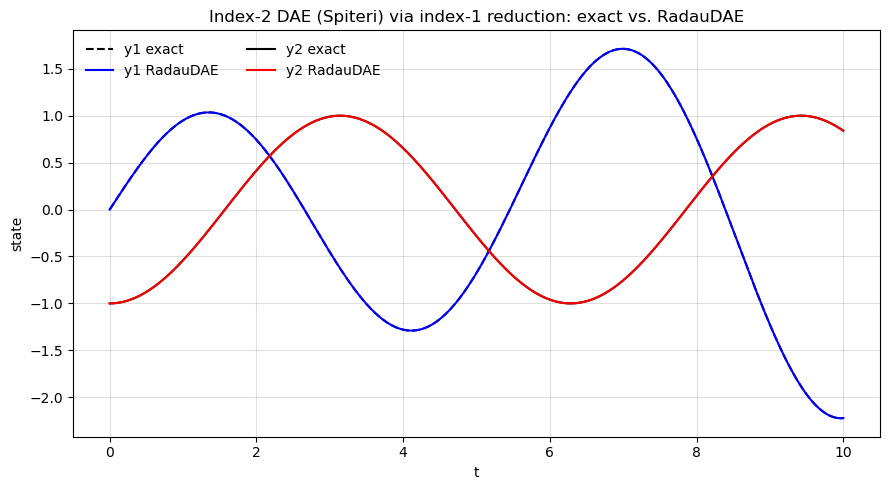

In [14]:
# Plot comparison
plt.figure(figsize=(9,5))
plt.plot(t_eval, y1_exact, 'k--', label='y1 exact')
plt.plot(t_eval, y1_num,   'b-',  label='y1 RadauDAE')
plt.plot(t_eval, y2_exact, 'k-', label='y2 exact')
plt.plot(t_eval, y2_num,   'r-',  label='y2 RadauDAE')
plt.xlabel('t')
plt.ylabel('state')
plt.title('Index-2 DAE (Spiteri) via index-1 reduction: exact vs. RadauDAE')
plt.legend(frameon=False, ncol=2)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()